In [1]:
# -*- coding: utf-8 -*-
"""
Training an image classifier
----------------------------
We will do the following steps in order:
1. Load and normalizing the MNIST training and test datasets using
   ``torchvision``
2. Define a SVM model
3. Define a loss function
4. Train the model on the training data
5. Test the model on the test data
1. Loading and normalizing MNIST
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Using ``torchvision``, it’s extremely easy to load MNIST.
"""
import torch
import torchvision
import torchvision.transforms as transforms
import itertools

########################################################################
# The output of torchvision datasets are PILImage images of range [0, 1].
# We transform them to Tensors of normalized range [-1, 1].
# .. note::
#     If running on Windows and you get a BrokenPipeError, try setting
#     the num_worker of torch.utils.data.DataLoader() to 0.

In [2]:
pytorch_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [69]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307,), (0.3081,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=16,
                                         shuffle=False, num_workers=2)

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


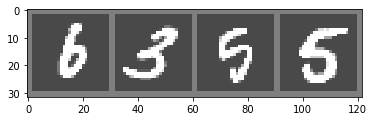

    6     3     5     5


In [6]:
########################################################################
# Let us show some of the training images, for fun.

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.show()

# get some random training images
examples = enumerate(trainloader)
batch_idx, (example_data, example_targets) = next(examples)

# show images
imshow(torchvision.utils.make_grid(example_data[:4]))


# print labels
print(' '.join('%5s' % classes[example_targets[j]] for j in range(4)))

In [9]:
########################################################################
# 2. Define a logit model
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

import torch.nn as nn
import torch.nn.functional as F


class Model(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Model, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim) ### YOUR CODE ###, ### YOUR CODE ###)
        
    def forward(self, x):
        # shape of input (=x): [16, 1, 28, 28]
        # shape of output: [16, 10]
        x = x.view(-1, 1 * 28 * 28)
        prediction = self.linear(x) ### YOUR CODE ####
        return prediction

model = Model(784,10).to(pytorch_device)

In [10]:
########################################################################
# 3. Define a Loss function and optimizer
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# Let's use a Classification Cross-Entropy loss and SGD with momentum.

import torch.optim as optim
lr_rate = 0.001
criterion = torch.nn.CrossEntropyLoss()### YOUR CODE ###
optimizer = optim.SGD(model.parameters(), lr=lr_rate)### YOUR CODE ###)

In [11]:
########################################################################
# 4. Train the model
# ^^^^^^^^^^^^^^^^^^^^
#
# This is when things start to get interesting.
# We simply have to loop over our data iterator, and feed the inputs to the
# model and optimize.

for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(pytorch_device), labels.to(pytorch_device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)### YOUR CODE ###
        loss.backward()### YOUR CODE ###
        optimizer.step()### YOUR CODE ###

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 0.739
[2,  2000] loss: 0.394
Finished Training


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


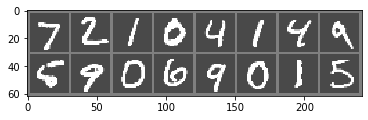

GroundTruth:      7     2     1     0     4     1     4     9     5     9     0     6     9     0     1     5
Predicted:      7     2     1     0     4     1     4     9     6     9     0     6     9     0     1     5
Accuracy of the model on the 60000 train images: 90 %
Accuracy of the model on the 10000 test images: 90 %
Accuracy of     0 : 97 %
Accuracy of     1 : 96 %
Accuracy of     2 : 86 %
Accuracy of     3 : 89 %
Accuracy of     4 : 91 %
Accuracy of     5 : 84 %
Accuracy of     6 : 93 %
Accuracy of     7 : 90 %
Accuracy of     8 : 86 %
Accuracy of     9 : 87 %


In [12]:
########################################################################
# See `here <https://pytorch.org/docs/stable/notes/serialization.html>`_
# for more details on saving PyTorch models.
#
# 5. Test the model on the test data
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
#
# We have trained the model for 2 passes over the training dataset.
# But we need to check if the model has learnt anything at all.
#
# We will check this by predicting the class label that the model
# outputs, and checking it against the ground-truth. If the prediction is
# correct, we add the sample to the list of correct predictions.
#
# Okay, first step. Let us display an image from the test set to get familiar.

dataiter = iter(testloader)
images, labels = dataiter.next()
images, labels = images.to(pytorch_device), labels.to(pytorch_device)

# print images
imshow(torchvision.utils.make_grid(images))

print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(len(labels))))

########################################################################
# Okay, now let us see what the model thinks these examples above are:

outputs = model(images)

########################################################################
# The outputs are energies for the 10 classes.
# The higher the energy for a class, the more the model
# thinks that the image is of the particular class.
# So, let's get the index of the highest energy:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(len(labels))))

########################################################################
# The results seem pretty good.
#
# Let us look at how the model performs on the whole dataset.

correct = 0
total = 0

with torch.no_grad():
    for data in trainloader:
        images, labels = data
        images, labels = images.to(pytorch_device), labels.to(pytorch_device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the model on the 60000 train images: %d %%' % (
    100 * correct / total))

correct = 0
total = 0

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
cmt = torch.zeros(10,10, dtype=torch.int64)


with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(pytorch_device), labels.to(pytorch_device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            cmt[labels[i], predicted[i]] += 1
            class_correct[label] += c[i].item()
            class_total[label] += 1


print('Accuracy of the model on the 10000 test images: %d %%' % (
    100 * correct / total))

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

In [13]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 958    0    2    2    0    5    8    1    4    0]
 [   0 1096    2    4    1    3    4    1   24    0]
 [  12   10  888   16   14    2   15   25   39   11]
 [   5    2   19  900    1   29    6   17   22    9]
 [   2    6    3    1  901    1   11    1   10   46]
 [  12    5    6   44   11  752   16   10   27    9]
 [  15    3    5    2   13   17  900    1    2    0]
 [   3   22   25    5    9    0    0  927    4   33]
 [  10   10    8   27    8   26   13   15  847   10]
 [  14    7    4   10   37   11    1   29   11  885]]


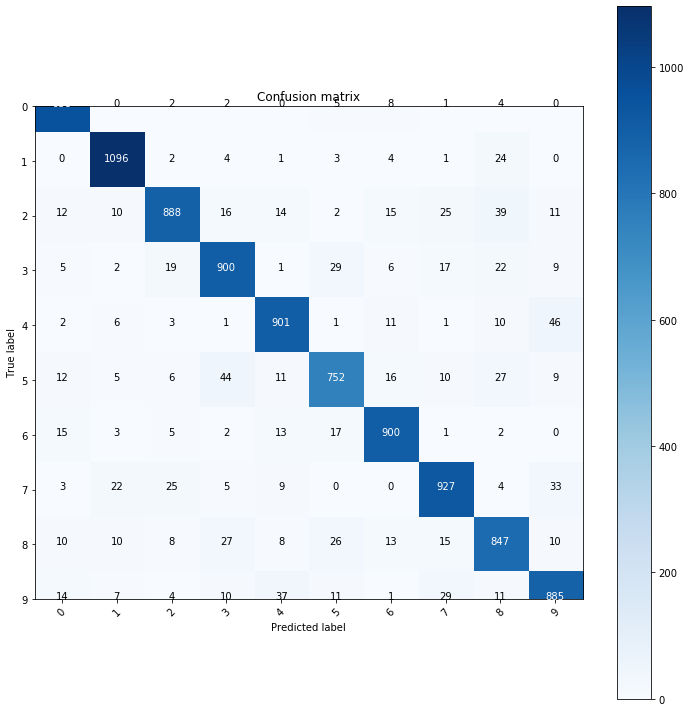

In [14]:
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cmt.numpy(), classes)

### Experiment with hyperparameters

### learning rate

#### lr = 0.01

In [23]:
########################################################################
# 4. Train the model
# ^^^^^^^^^^^^^^^^^^^^
#
# This is when things start to get interesting.
# We simply have to loop over our data iterator, and feed the inputs to the
# model and optimize.

lr_rate = 0.01
criterion = torch.nn.CrossEntropyLoss()### YOUR CODE ###
optimizer = optim.SGD(model.parameters(), lr=lr_rate)### YOUR CODE ###)

for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(pytorch_device), labels.to(pytorch_device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)### YOUR CODE ###
        loss.backward()### YOUR CODE ###
        optimizer.step()### YOUR CODE ###

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 0.336
[2,  2000] loss: 0.298
Finished Training


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


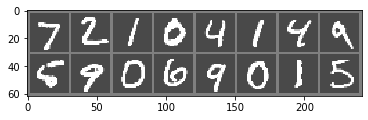

GroundTruth:      7     2     1     0     4     1     4     9     5     9     0     6     9     0     1     5
Predicted:      7     2     1     0     4     1     4     9     6     9     0     6     9     0     1     5
Accuracy of the model on the 60000 train images: 92 %
Accuracy of the model on the 10000 test images: 91 %
Accuracy of     0 : 98 %
Accuracy of     1 : 97 %
Accuracy of     2 : 89 %
Accuracy of     3 : 92 %
Accuracy of     4 : 94 %
Accuracy of     5 : 83 %
Accuracy of     6 : 94 %
Accuracy of     7 : 93 %
Accuracy of     8 : 89 %
Accuracy of     9 : 84 %


In [24]:
########################################################################
# See `here <https://pytorch.org/docs/stable/notes/serialization.html>`_
# for more details on saving PyTorch models.
#
# 5. Test the model on the test data
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
#
# We have trained the model for 2 passes over the training dataset.
# But we need to check if the model has learnt anything at all.
#
# We will check this by predicting the class label that the model
# outputs, and checking it against the ground-truth. If the prediction is
# correct, we add the sample to the list of correct predictions.
#
# Okay, first step. Let us display an image from the test set to get familiar.

dataiter = iter(testloader)
images, labels = dataiter.next()
images, labels = images.to(pytorch_device), labels.to(pytorch_device)

# print images
imshow(torchvision.utils.make_grid(images))

print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(len(labels))))

########################################################################
# Okay, now let us see what the model thinks these examples above are:

outputs = model(images)

########################################################################
# The outputs are energies for the 10 classes.
# The higher the energy for a class, the more the model
# thinks that the image is of the particular class.
# So, let's get the index of the highest energy:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(len(labels))))

########################################################################
# The results seem pretty good.
#
# Let us look at how the model performs on the whole dataset.

correct = 0
total = 0

with torch.no_grad():
    for data in trainloader:
        images, labels = data
        images, labels = images.to(pytorch_device), labels.to(pytorch_device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the model on the 60000 train images: %d %%' % (
    100 * correct / total))

correct = 0
total = 0

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
cmt = torch.zeros(10,10, dtype=torch.int64)


with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(pytorch_device), labels.to(pytorch_device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            cmt[labels[i], predicted[i]] += 1
            class_correct[label] += c[i].item()
            class_total[label] += 1


print('Accuracy of the model on the 10000 test images: %d %%' % (
    100 * correct / total))

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

#### lr = 0.1

In [29]:
########################################################################
# 4. Train the model
# ^^^^^^^^^^^^^^^^^^^^
#
# This is when things start to get interesting.
# We simply have to loop over our data iterator, and feed the inputs to the
# model and optimize.

lr_rate = 0.1
criterion = torch.nn.CrossEntropyLoss()### YOUR CODE ###
optimizer = optim.SGD(model.parameters(), lr=lr_rate)### YOUR CODE ###)

for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(pytorch_device), labels.to(pytorch_device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)### YOUR CODE ###
        loss.backward()### YOUR CODE ###
        optimizer.step()### YOUR CODE ###

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 0.506
[2,  2000] loss: 0.500
Finished Training


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


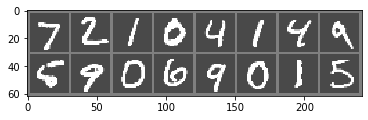

GroundTruth:      7     2     1     0     4     1     4     9     5     9     0     6     9     0     1     5
Predicted:      7     2     1     0     4     1     4     9     6     9     0     6     9     0     1     5
Accuracy of the model on the 60000 train images: 85 %
Accuracy of the model on the 10000 test images: 85 %
Accuracy of     0 : 95 %
Accuracy of     1 : 85 %
Accuracy of     2 : 92 %
Accuracy of     3 : 74 %
Accuracy of     4 : 91 %
Accuracy of     5 : 90 %
Accuracy of     6 : 74 %
Accuracy of     7 : 93 %
Accuracy of     8 : 87 %
Accuracy of     9 : 72 %


In [30]:
########################################################################
# See `here <https://pytorch.org/docs/stable/notes/serialization.html>`_
# for more details on saving PyTorch models.
#
# 5. Test the model on the test data
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
#
# We have trained the model for 2 passes over the training dataset.
# But we need to check if the model has learnt anything at all.
#
# We will check this by predicting the class label that the model
# outputs, and checking it against the ground-truth. If the prediction is
# correct, we add the sample to the list of correct predictions.
#
# Okay, first step. Let us display an image from the test set to get familiar.

dataiter = iter(testloader)
images, labels = dataiter.next()
images, labels = images.to(pytorch_device), labels.to(pytorch_device)

# print images
imshow(torchvision.utils.make_grid(images))

print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(len(labels))))

########################################################################
# Okay, now let us see what the model thinks these examples above are:

outputs = model(images)

########################################################################
# The outputs are energies for the 10 classes.
# The higher the energy for a class, the more the model
# thinks that the image is of the particular class.
# So, let's get the index of the highest energy:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(len(labels))))

########################################################################
# The results seem pretty good.
#
# Let us look at how the model performs on the whole dataset.

correct = 0
total = 0

with torch.no_grad():
    for data in trainloader:
        images, labels = data
        images, labels = images.to(pytorch_device), labels.to(pytorch_device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the model on the 60000 train images: %d %%' % (
    100 * correct / total))

correct = 0
total = 0

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
cmt = torch.zeros(10,10, dtype=torch.int64)


with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(pytorch_device), labels.to(pytorch_device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            cmt[labels[i], predicted[i]] += 1
            class_correct[label] += c[i].item()
            class_total[label] += 1


print('Accuracy of the model on the 10000 test images: %d %%' % (
    100 * correct / total))

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

## So, a very high learning rate does more damage than good. Especially when using SGD where we process the data in batches

### Num of epochs

#### epochs = 10

In [32]:
########################################################################
# 4. Train the model
# ^^^^^^^^^^^^^^^^^^^^
#
# This is when things start to get interesting.
# We simply have to loop over our data iterator, and feed the inputs to the
# model and optimize.

lr_rate = 0.01
criterion = torch.nn.CrossEntropyLoss()### YOUR CODE ###
optimizer = optim.SGD(model.parameters(), lr=lr_rate)### YOUR CODE ###)

for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(pytorch_device), labels.to(pytorch_device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)### YOUR CODE ###
        loss.backward()### YOUR CODE ###
        optimizer.step()### YOUR CODE ###

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 0.334
[2,  2000] loss: 0.282
[3,  2000] loss: 0.266
[4,  2000] loss: 0.265
[5,  2000] loss: 0.251
[6,  2000] loss: 0.250
[7,  2000] loss: 0.247
[8,  2000] loss: 0.255
[9,  2000] loss: 0.244
[10,  2000] loss: 0.243
Finished Training


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


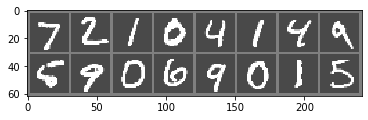

GroundTruth:      7     2     1     0     4     1     4     9     5     9     0     6     9     0     1     5
Predicted:      7     2     1     0     4     1     4     9     6     9     0     6     9     0     1     5
Accuracy of the model on the 60000 train images: 93 %
Accuracy of the model on the 10000 test images: 92 %
Accuracy of     0 : 98 %
Accuracy of     1 : 97 %
Accuracy of     2 : 92 %
Accuracy of     3 : 90 %
Accuracy of     4 : 93 %
Accuracy of     5 : 86 %
Accuracy of     6 : 95 %
Accuracy of     7 : 92 %
Accuracy of     8 : 87 %
Accuracy of     9 : 88 %


In [33]:
########################################################################
# See `here <https://pytorch.org/docs/stable/notes/serialization.html>`_
# for more details on saving PyTorch models.
#
# 5. Test the model on the test data
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
#
# We have trained the model for 2 passes over the training dataset.
# But we need to check if the model has learnt anything at all.
#
# We will check this by predicting the class label that the model
# outputs, and checking it against the ground-truth. If the prediction is
# correct, we add the sample to the list of correct predictions.
#
# Okay, first step. Let us display an image from the test set to get familiar.

dataiter = iter(testloader)
images, labels = dataiter.next()
images, labels = images.to(pytorch_device), labels.to(pytorch_device)

# print images
imshow(torchvision.utils.make_grid(images))

print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(len(labels))))

########################################################################
# Okay, now let us see what the model thinks these examples above are:

outputs = model(images)

########################################################################
# The outputs are energies for the 10 classes.
# The higher the energy for a class, the more the model
# thinks that the image is of the particular class.
# So, let's get the index of the highest energy:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(len(labels))))

########################################################################
# The results seem pretty good.
#
# Let us look at how the model performs on the whole dataset.

correct = 0
total = 0

with torch.no_grad():
    for data in trainloader:
        images, labels = data
        images, labels = images.to(pytorch_device), labels.to(pytorch_device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the model on the 60000 train images: %d %%' % (
    100 * correct / total))

correct = 0
total = 0

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
cmt = torch.zeros(10,10, dtype=torch.int64)


with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(pytorch_device), labels.to(pytorch_device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            cmt[labels[i], predicted[i]] += 1
            class_correct[label] += c[i].item()
            class_total[label] += 1


print('Accuracy of the model on the 10000 test images: %d %%' % (
    100 * correct / total))

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

### Adding few more epochs has improved the performance. But one should be careful not to overfit the training data

## Batch-size

In [43]:
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=8,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=8,
                                         shuffle=False, num_workers=2)

In [47]:
########################################################################
# 4. Train the model
# ^^^^^^^^^^^^^^^^^^^^
#
# This is when things start to get interesting.
# We simply have to loop over our data iterator, and feed the inputs to the
# model and optimize.

lr_rate = 0.001
criterion = torch.nn.CrossEntropyLoss()### YOUR CODE ###
optimizer = optim.SGD(model.parameters(), lr=lr_rate)### YOUR CODE ###)

for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(pytorch_device), labels.to(pytorch_device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)### YOUR CODE ###
        loss.backward()### YOUR CODE ###
        optimizer.step()### YOUR CODE ###

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 0.213
[1,  4000] loss: 0.224
[1,  6000] loss: 0.218
[2,  2000] loss: 0.227
[2,  4000] loss: 0.223
[2,  6000] loss: 0.216
Finished Training


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


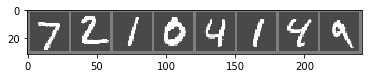

GroundTruth:      7     2     1     0     4     1     4     9
Predicted:      7     2     1     0     4     1     4     9
Accuracy of the model on the 60000 train images: 94 %
Accuracy of the model on the 10000 test images: 92 %
Accuracy of     0 : 97 %
Accuracy of     1 : 97 %
Accuracy of     2 : 90 %
Accuracy of     3 : 90 %
Accuracy of     4 : 93 %
Accuracy of     5 : 86 %
Accuracy of     6 : 96 %
Accuracy of     7 : 92 %
Accuracy of     8 : 86 %
Accuracy of     9 : 90 %


In [48]:
########################################################################
# See `here <https://pytorch.org/docs/stable/notes/serialization.html>`_
# for more details on saving PyTorch models.
#
# 5. Test the model on the test data
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
#
# We have trained the model for 2 passes over the training dataset.
# But we need to check if the model has learnt anything at all.
#
# We will check this by predicting the class label that the model
# outputs, and checking it against the ground-truth. If the prediction is
# correct, we add the sample to the list of correct predictions.
#
# Okay, first step. Let us display an image from the test set to get familiar.

dataiter = iter(testloader)
images, labels = dataiter.next()
images, labels = images.to(pytorch_device), labels.to(pytorch_device)

# print images
imshow(torchvision.utils.make_grid(images))

print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(len(labels))))

########################################################################
# Okay, now let us see what the model thinks these examples above are:

outputs = model(images)

########################################################################
# The outputs are energies for the 10 classes.
# The higher the energy for a class, the more the model
# thinks that the image is of the particular class.
# So, let's get the index of the highest energy:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(len(labels))))

########################################################################
# The results seem pretty good.
#
# Let us look at how the model performs on the whole dataset.

correct = 0
total = 0

with torch.no_grad():
    for data in trainloader:
        images, labels = data
        images, labels = images.to(pytorch_device), labels.to(pytorch_device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the model on the 60000 train images: %d %%' % (
    100 * correct / total))

correct = 0
total = 0

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
cmt = torch.zeros(10,10, dtype=torch.int64)


with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(pytorch_device), labels.to(pytorch_device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            cmt[labels[i], predicted[i]] += 1
            class_correct[label] += c[i].item()
            class_total[label] += 1


print('Accuracy of the model on the 10000 test images: %d %%' % (
    100 * correct / total))

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

### So, with all the parameters remaining the same, decreasing the batch size has improved the performance. But in general there is a trade-off between the batch size and num of steps to converge to a minima. The extreme case of making the batch size equal to the size of dataset probably requires more iterations to converge but at each step you go in the right direction. Where as a smaller batch size would might not go in the right direction of minima but probably requires less number of steps

### SVM

In [70]:
########################################################################
# 2. Define a SVM model
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

import torch.nn as nn
import torch.nn.functional as F


class Model(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Model, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim) ### YOUR CODE ###, ### YOUR CODE ###)
        
    def forward(self, x):
        # shape of input (=x): [16, 1, 28, 28]
        # shape of output: [16, 10]
        x = x.view(-1, 1 * 28 * 28)
        prediction = self.linear(x) ### YOUR CODE ####
        return prediction

model = Model(784,10).to(pytorch_device)

In [71]:
lr_rate = 0.001
criterion = torch.nn.MultiMarginLoss()### YOUR CODE ###
optimizer = optim.SGD(model.parameters(), lr=lr_rate)### YOUR CODE ###)

In [72]:
########################################################################
# 4. Train the model
# ^^^^^^^^^^^^^^^^^^^^
#
# This is when things start to get interesting.
# We simply have to loop over our data iterator, and feed the inputs to the
# model and optimize.

for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(pytorch_device), labels.to(pytorch_device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)### YOUR CODE ###
        loss.backward()### YOUR CODE ###
        optimizer.step()### YOUR CODE ###

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 0.146
[2,  2000] loss: 0.063
[3,  2000] loss: 0.056
[4,  2000] loss: 0.051
[5,  2000] loss: 0.049
[6,  2000] loss: 0.048
[7,  2000] loss: 0.046
[8,  2000] loss: 0.045
[9,  2000] loss: 0.043
[10,  2000] loss: 0.044
Finished Training


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


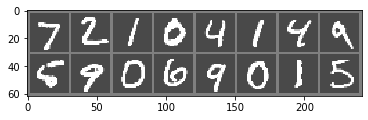

GroundTruth:      7     2     1     0     4     1     4     9     5     9     0     6     9     0     1     5
Predicted:      7     2     1     0     4     1     4     9     6     9     0     6     9     0     1     5
Accuracy of the model on the 60000 train images: 91 %
Accuracy of the model on the 10000 test images: 91 %
Accuracy of     0 : 96 %
Accuracy of     1 : 97 %
Accuracy of     2 : 87 %
Accuracy of     3 : 88 %
Accuracy of     4 : 92 %
Accuracy of     5 : 85 %
Accuracy of     6 : 93 %
Accuracy of     7 : 91 %
Accuracy of     8 : 87 %
Accuracy of     9 : 89 %


In [73]:
########################################################################
# See `here <https://pytorch.org/docs/stable/notes/serialization.html>`_
# for more details on saving PyTorch models.
#
# 5. Test the model on the test data
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
#
# We have trained the model for 2 passes over the training dataset.
# But we need to check if the model has learnt anything at all.
#
# We will check this by predicting the class label that the model
# outputs, and checking it against the ground-truth. If the prediction is
# correct, we add the sample to the list of correct predictions.
#
# Okay, first step. Let us display an image from the test set to get familiar.

dataiter = iter(testloader)
images, labels = dataiter.next()
images, labels = images.to(pytorch_device), labels.to(pytorch_device)

# print images
imshow(torchvision.utils.make_grid(images))

print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(len(labels))))

########################################################################
# Okay, now let us see what the model thinks these examples above are:

outputs = model(images)

########################################################################
# The outputs are energies for the 10 classes.
# The higher the energy for a class, the more the model
# thinks that the image is of the particular class.
# So, let's get the index of the highest energy:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(len(labels))))

########################################################################
# The results seem pretty good.
#
# Let us look at how the model performs on the whole dataset.

correct = 0
total = 0

with torch.no_grad():
    for data in trainloader:
        images, labels = data
        images, labels = images.to(pytorch_device), labels.to(pytorch_device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the model on the 60000 train images: %d %%' % (
    100 * correct / total))

correct = 0
total = 0

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
cmt = torch.zeros(10,10, dtype=torch.int64)


with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(pytorch_device), labels.to(pytorch_device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            cmt[labels[i], predicted[i]] += 1
            class_correct[label] += c[i].item()
            class_total[label] += 1


print('Accuracy of the model on the 10000 test images: %d %%' % (
    100 * correct / total))

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Confusion matrix, without normalization
[[ 948    0    3    2    0   12   11    1    2    1]
 [   0 1102    2    3    1    4    4    1   18    0]
 [  10    8  901   14   16    3   18   15   43    4]
 [   4    1   19  898    0   42    3   16   20    7]
 [   1    2    4    2  911    1   10    3    6   42]
 [   9    4    5   38   12  767   17    7   24    9]
 [   8    3    8    1   18   17  898    2    3    0]
 [   4    8   23    7    6    1    0  940    2   37]
 [   9    7    8   18    9   33   13   11  852   14]
 [  11    7    3   11   40    5    0   24    8  900]]


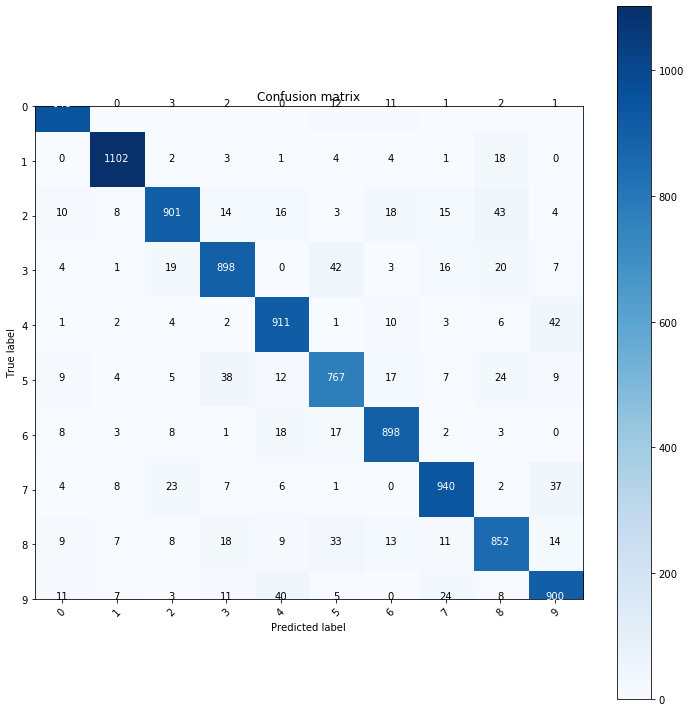

In [74]:
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cmt.numpy(), classes)